In [1]:
import logging
import warnings
import itertools
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, find_peaks_cwt

logging.disable(logging.WARNING)
warnings.filterwarnings('ignore')


## Functions

In [2]:
def adf_test(time_series):
    """
    param time_series: takes a time series list as an input
    return: True/False as a results of KPSS alongside the output in dataframe
    """
    dftest = adfuller(time_series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=[
                             'Test Statistic', 'p-value', '#Lags Used',
                             'Number of Observations Used'
                         ])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value

    if dfoutput['p-value'] < 0.01:
        return True, dfoutput
    else:
        return False, dfoutput


def kpss_test(time_series):
    kpsstest = kpss(time_series, regression='c')
    dfoutput = pd.Series(kpsstest[0:3],
                         index=['Test Statistic', 'p-value', 'Lags Used'])
    for key, value in kpsstest[3].items():
        dfoutput['Critical Value (%s)' % key] = value

    if dfoutput['p-value'] < 0.01:
        return False, dfoutput
    else:
        return True, dfoutput


def most_frequent(list):
    counter = 0
    num = list[0]

    for i in list:
        curr_frequency = list.count(i)
        if curr_frequency > counter:
            counter = curr_frequency
            num = i
    return num


def identify_cont_disc(df):
    """
    :param df: the metric data column(s) that has no NAN or constant values
    :return: list of continuous metrics and their corresponding data column(s)
    """
    raw_feature_list = df.columns
    raw_feature_list = list(raw_feature_list.values)

    # feature_list = df.columns
    discrete_features = []
    continuous_features = []
    for colum in raw_feature_list:
        if len(df[colum].unique()) < 20:
            # print(colum, ': ', df[colum].unique())
            discrete_features.append(colum)
        else:
            # print(colum, ": continuous features")
            continuous_features.append(colum)
    df_cont = df[continuous_features].copy()

    df_disc = df[discrete_features].copy()

    return continuous_features, discrete_features


def analysisPeriod(df_raw, feature, time_feature, plot=False, verbose=False):
    """
    :param df_raw: data set
    :param feature: metric name
    :param time_feature: time series name
    :param plot: visual analysis functionality
    :param verbose: print details on the console
    :return: stationary, seasonal, period, decomposed series
    """

    ## INITIALIZATION: time series should be normalised into [0, 1]

    seasonal = False
    stationary = False
    df_ts = df_raw.copy()

    # Stationary Check
    # ADF TEST: Augmented Dickey–Fuller test
    # KPSS TEST: Kwiatkowski–Phillips–Schmidt–Shin TEST
    adf_result, adf_output = adf_test(df_ts[feature])
    kpss_result, kpss_output = kpss_test(df_ts[feature])

    if verbose:
        print('adf-Test')
        print(adf_result)
        print(adf_output)
        print('kpss-Test')
        print(kpss_result)
        print(kpss_output)

    # This is the code to use two tests, it will return true for stationary if or(test1,test2) = True
    if adf_result == True & kpss_result == True:
        stationary = True
    elif adf_result == True & kpss_result == False:
        stationary = False
        print("Difference Stationary")
    elif adf_result == False & kpss_result == True:
        stationary = False
        print("Trend Stationary")
    else:
        stationary = False

    # First: checking flat line.
    if np.all(np.isclose(df_ts[feature].values, df_ts[feature].values[0])):
        print('Constant series')
        seasonal = False
        period = 1
        result_add = None
    else:
        # If not flat line then:
        # Seasonality Check:

        # Automatic find the period based on Time Index

        # Shift windows to find autocorrelations
        shift_ = []
        for i in np.arange(len(df_ts[feature])):
            shift_.append(df_ts[feature].autocorr(lag=i))
        shift_ = np.array(shift_)

        # if max of Autocorelation greater than 0.9, we have seasonal
        if max(shift_) >= 0.9:
            seasonal = True

        # find peaks of autocorelation -> in order to find local maxima
        # peaks, _ = find_peaks(shift_, height=0.5)
        peaks = find_peaks_cwt(shift_, np.arange(1, 10))

        # turn peaks into differences between peaks
        diff = []
        for i in np.arange(len(peaks) - 1):
            diff.append(peaks[i + 1] - peaks[i])

        if len(diff) == 0:  # can't find peaks
            first_period = 1  # need to check again this!
        else:
            # return the most distance between peaks -> that is period of data
            first_period = most_frequent(list(diff))

        if verbose:
            #print('Candidate periods:', set(diff))
            for eachdiff in diff:
                print(df_ts[feature].autocorr(lag=eachdiff), end='\t')
            print()

        if (plot == True) & (verbose == True):
            plt.figure(figsize=(20, 3))
            sm.graphics.tsa.plot_acf(df_ts[feature].squeeze(),
                                     lags=int(first_period))

        # if period is too large
        if first_period > int(len(df_ts) / 2):
            if verbose:
                print('Frequency for Moving Average is over half size!')
            first_period = int(len(df_ts) / 2)

        # SEASONAL ANALYSIS

        if verbose:
            print('First period:', first_period)

        df_ts.index = pd.to_datetime(df_ts[time_feature],
                                     format='%Y-%m-%d %H:%M:%S')
        rolling_mean = df_ts[feature].rolling(window=int(first_period)).mean()
        
        exp1 = pd.Series(df_ts[feature].ewm(span=int(first_period),
                                            adjust=False).mean())
        
        exp1.index = pd.to_datetime(df_ts[time_feature],
                                    format='%Y-%m-%d %H:%M:%S')

        if (verbose == True) & (plot == True):
            df_ori = df_ts[[feature, time_feature]].copy()
            df_ori.set_index(time_feature, inplace=True)

            fig, ax = plt.subplots(figsize=(15, 4))

            df_ori.plot(ax=ax)
            exp1.plot(ax=ax)

            ax.legend([
                'Original Series',
                'Moving Average Series with P=%d' % first_period
            ])

            plt.show()

        # Using Moving Average
        result_add = seasonal_decompose(exp1,
                                        model='additive',
                                        extrapolate_trend='freq',
                                        freq=first_period)

        # Using STL
        #         from statsmodels.tsa.seasonal import STL
        #         stl = STL(exp1, period=first_period, robust=True)
        #         result_add = stl.fit()

        # Only check the seasonal series to find again the best period
        arr_seasonal_ = pd.Series(result_add.seasonal + result_add.resid)

        # if seasonal is flat
        if np.all(np.isclose(arr_seasonal_, arr_seasonal_[0])):
            if verbose == True:
                print('Seasonal + Residual become flat')
            seasonal = False
            period = 1
        else:
            # if seasonal is not flat

            # Continue to use autocorrelation to find the period
            shift_ = []
            for i in np.arange(len(arr_seasonal_)):
                shift_.append(arr_seasonal_.autocorr(lag=i))

            shift_ = np.array(shift_)

            # Find peaks again for seasonal + residual
            peaks, _ = find_peaks(shift_, height=0.85, distance=7)
            #             peaks = find_peaks_cwt(shift_,np.arange(1,10))

            # Looking for possible periods
            if len(peaks) < 2:
                if df_ts[feature].autocorr(lag=first_period) > 0.80:
                    period = first_period
                    seasonal = True
                else:
                    period = 1
                    seasonal = False
                    result_add = None
            # result_add = seasonal_decompose(df_ts[feature], model='additive', extrapolate_trend='freq',freq=period)
            else:
                diff = []
                for i in np.arange(len(peaks)):
                    if i + 1 < len(peaks):
                        diff.append(peaks[i + 1] - peaks[i])

                if verbose:
                    print('Candidate periods:', set(diff))
                    for eachdiff in diff:
                        print(df_ts[feature].autocorr(lag=eachdiff), end='\t')
                    print()

                if verbose:
                    print('Peaks of autocorr:', diff)
                if 2 * most_frequent(list(diff)) > len(df_ts):
                    seasonal = False
                    period = 1
                    result_add = None
                else:
                    seasonal = True
                    period = most_frequent(list(diff))

            if (plot == True) & (verbose == True):
                sm.graphics.tsa.plot_acf(exp1.squeeze(), lags=int(period) * 2)
                plt.show()

            # Final Decomposition

            result_add = seasonal_decompose(df_ts[feature],
                                            model='additive',
                                            extrapolate_trend='freq',
                                            freq=period)

            # plot results of decomposition
            if plot:
                plt.rcParams.update({'figure.figsize': (10, 10)})
                result_add.plot()
                plt.show()

                plt.figure(figsize=(20, 3))
                plt.plot(df_ts[feature].values, label="Timeseries")
                plt.axvline(x=0, color='r', ls='--')
                plt.axvline(x=period, color='r', ls='--')
                plt.grid(True)
                plt.axis('tight')
                plt.legend(loc="best", fontsize=13)
                plt.show()

    continuous, discrete = identify_cont_disc(df_raw[[feature]])

    return stationary, seasonal, period, result_add, continuous, discrete

## Timeseries Analysis

adf-Test
True
Test Statistic                -1.252788e+01
p-value                        2.465570e-23
#Lags Used                     2.800000e+01
Number of Observations Used    8.970000e+03
Critical Value (1%)           -3.431079e+00
Critical Value (5%)           -2.861862e+00
Critical Value (10%)          -2.566942e+00
dtype: float64
kpss-Test
True
Test Statistic            0.346009
p-value                   0.100000
Lags Used                37.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
0.2739200453818752	-0.030402540085861813	0.1471778056672017	-0.0206163394552713	0.9481135781097084	-0.0668143239067106	0.19206398112064335	0.4023817614991674	-0.04938120066471061	0.2079650318272513	0.38150385078419063	-0.015624801328930502	0.2574597714703722	0.2739200453818752	0.2407293884533324	0.16160332107760234	-0.02562795574158935	-0.006672754373247139	0.44802156284535016	0.257459

<Figure size 1440x216 with 0 Axes>

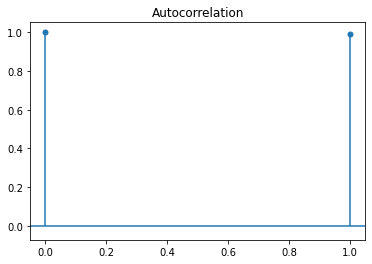

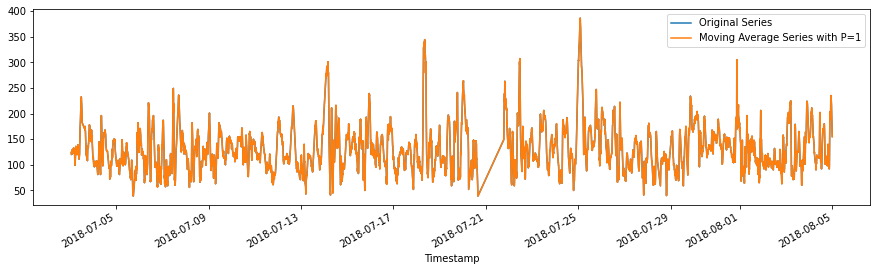

Seasonal + Residual become flat
Timeseries glucose is Stationary? True 
Timeseries glucose is Seasonal? False 
Timeseries glucose is Continuous


In [3]:
df=pd.read_csv(r'C:\Users\ahtis\OneDrive\Desktop\ARIMA\data\data.csv')
df = df.dropna()
df = df[1:9000]

feature_name = "glucose"  

df["Timestamp"] = pd.to_datetime(df["Timestamp"], format='%Y-%m-%d %H:%M:%S', utc=True)
#df_weather["Timestamp"] = pd.DatetimeIndex(df_weather["Timestamp"], tz='Europe/Berlin')

Timestamp = df.columns[0]

stationary, seasonal, period, resultdfs, continuous, discrete = analysisPeriod(
    df,
    feature=feature_name,
    time_feature=Timestamp,
    plot=True,
    verbose=True)

print("Timeseries %s is Stationary? %s " % (feature_name, stationary))

print("Timeseries %s is Seasonal? %s " % (feature_name, seasonal))

if seasonal and period > 1:
    print("Period for Timeseries %s =  %s " % (feature_name, period))
if seasonal and period == 1:
    print("Period for Timeseries %s is not found" % (feature_name, period))

if continuous:
    print("Timeseries %s is Continuous" % (feature_name))
else:
    print("Timeseries %s is Discrete" % (feature_name))